# 11. Alignment of Model Scales

## Numerical experiments - Week 04/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

The goal of this study is to verify the effect of spore clustering without the bias caused by narrow absorbing boundaries, and to pursue a universal mathematical relationship between cell wall permeability, spore density and spore coverage due to clustering.

## Prerequisite libraries

In [2]:
using PyPlot
using CurveFit
using Revise
using JLD2

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis

## 1. Coarse high-resolution simulations with larger boundaries

To expand the boundaries of the high-resolution model, while still preserving a sufficient level of detail, the spatial increment is set to $\Delta{x}=0.4\ \mu\textrm{m}$ and a lattice with $N=256$ subdivisions is simulated, equivalent to a length of $L=102.4\ \mu\textrm{m}$ in each dimension. At this spore-to-spore distance, the external saturation effect does not bias results significantly. Spore clusters of different neighbour counts and symmetries are tested, first under the assumption of an diffusion-inaccessible spore interior. The time-precision is increased to $\Delta{t}=0.01$.

In [ ]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 256
dx = 0.4 # 1 cell is 0.40 um long

# High resolution (implicit)
dt = 0.01
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# Simulation parameters (neighbours, trim)
# param_set = [(2, true), (2, false), (3, false), (4, false), (6, true), (6, false), (8, false), (12, false)]
# param_set = [(2, false), (3, false), (4, false), (6, false), (8, false), (12, false)]
param_set = [(2, true), (3, true), (4, true), (2, false), (3, false), (8, true), (4, false), (6, true), (6, false), (12, true), (8, false), (12, false)]

nbr_nums = [0]
exponents = []
c_finals = []

# Run single spore simulation
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, [spore_center_idx], spore_rad, t_max;
                                                                                                    D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                    crank_nicolson=false, abs_bndry=true)
fit = exp_fit(times_numerical, c_numerical)
push!(exponents, fit[2])
push!(c_finals, c_numerical[end])

# Run spore cluster simulations
for (n_nbrs, trim) in param_set
    println("Running simulation with $(n_nbrs) neighbours and trim: $(trim)")
    sp_cen_indices = setup_spore_cluster(n_nbrs, N, spore_rad / dx, trim)
    push!(nbr_nums, length(sp_cen_indices) - 1)
    sp_cen_coords = [(i[1] * dx, i[2] * dx, i[3] * dx) for i in sp_cen_indices]
    c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, sp_cen_indices, spore_rad, t_max;
                                                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                        crank_nicolson=false, abs_bndry=true)
    push!(c_finals, c_numerical[end])
    fit = exp_fit(times_numerical, c_numerical)
    push!(exponents, fit[2])
end

Spore radius in lattice units: 6.25
Using D = 600, Db = 7.134274852031516e-5, Dcw = 3.5671376380902605e-5
D*dt/dx2 = 37.49999999999999, Db*dt/dx2 = 4.4589217825196964e-6, Dcw*dt/dx2 = 2.2294610238064124e-6
Timescale for accuracy: 0.00026666666666666673
Storage arrays allocated.
1.499999977582582
Frame 1 saved.1.4004846698039892
Frame 2 saved.1.3075104796571202
Frame 3 saved.1.2206524849872047
Frame 4 saved.1.1395296690863328
Frame 5 saved.1.0639003535092286
Frame 6 saved.0.9932476766662897
Frame 7 saved.0.9272958202530189
Frame 8 saved.0.8657804782430292
Frame 9 saved.0.8083007057780267
Frame 10 saved.0.7545844955145435
Frame 11 saved.0.7044807587267721
Frame 12 saved.0.6577056185155377
Frame 13 saved.0.6140367688207972
Frame 14 saved.0.5732380491512645
Frame 15 saved.0.5351703991268804
Frame 16 saved.0.4996263198591002
Frame 17 saved.0.46647433319241244
Frame 18 saved.0.43552377198281883
Frame 19 saved.0.40658897097267194
Frame 20 saved.0.37958438202636596
Frame 21 saved.0.35435220753

In [5]:
# Save results to files
path = @__DIR__

# Create experiment directory if it doesn't exist
if !isdir("$(path)/Data/250425_cluster_studies")
    mkdir("$(path)/Data/250425_cluster_studies")
end

jldopen(joinpath(path, "Data", "250425_cluster_studies", "250425_cluster_studies_sims.jld2"), "w") do file
    file["c_finals"] = c_finals
    file["nbr_nums"] = nbr_nums
    file["exponents"] = exponents
    file["param_set"] = param_set
end

12-element Vector{Tuple{Int64, Bool}}:
 (2, 1)
 (3, 1)
 (4, 1)
 (2, 0)
 (3, 0)
 (8, 1)
 (4, 0)
 (6, 1)
 (6, 0)
 (12, 1)
 (8, 0)
 (12, 0)

The resulting functional relationship between cluster size and release exponent is plotted below.

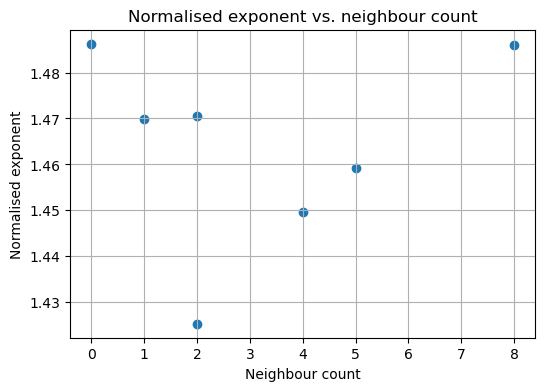

In [35]:
# Normalise exponents with tau
A_spore, V_spore = compute_spore_area_and_volume_from_dia(5.0)
tau = V_spore / (Ps_fit * A_spore)
exp_norm = -exponents .* tau

symmetric_mask = vcat([true], [ps[2] for ps in param_set])

plot_functional_relationship(nbr_nums[symmetric_mask], exp_norm[symmetric_mask], ["Neighbour count", "Normalised exponent"], "Normalised exponent vs. neighbour count", fit=nothing, scatter=true)
# plot_functional_relationship(nbr_nums[2:end], c_finals, ["Neighbour count", "c(4 h)"], "Final concentration vs. neighbour count", fit=nothing, scatter=true)

Beside the slight fluctuation of the release exponent and the final concentration, there is no distinguishable pattern in its influence by the neighbour count. A possible reason for this is due to discretisation artifacts that vary the number of contact sites depending on the spatial arrangement of the clusters. As the coarser resolution increases the ratio of these contact sites to the overall area, the position of a neighbour orthogonally vs. diagonally to the central spore with respect to the lattice grid can greatly influence the results. 

## 2. Fine high-resolution simulations with larger boundaries

To overcome the above discretisation effect but still incorporate large spatial boundaries, the spatial increment is reduced to $\Delta{x}=0.15\ \mu\textrm{m}$, the equivalent of one quarter of a $400\ \textrm{nm}$ cell wall. The lattice size is kept at $N=256$, which under the current setup is equal to $L=25.6\ \mu\textrm{m}$. The simulated time-frame is reduced to 1 hour. A full spore volume, accessible to diffusion, is considered.

In [8]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 3600 # s
c0_spore = 1.5 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 256
dx = 0.1 # 1 cell is 0.15 um long

# High resolution (implicit)
dt = 0.01
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# Simulation parameters (neighbours, trim)
# param_set = [(2, true), (2, false), (3, false), (4, false), (6, true), (6, false), (8, false), (12, false)]
# param_set = [(2, false), (3, false), (4, false), (6, false), (8, false), (12, false)]
param_set = [(2, true), (3, true), (4, true), (2, false), (3, false), (8, true), (4, false), (6, true), (6, false), (12, true), (8, false), (12, false)]

nbr_nums = [0]
exponents = []
c_finals = []
region_ids_all = []

# Run single spore simulation
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, [spore_center_idx], spore_rad, t_max;
                                                                                                    D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                    crank_nicolson=false, abs_bndry=true, corr_factor=2.2, empty_interior=false)
fit = exp_fit(times_numerical, c_numerical)
push!(exponents, fit[2])
push!(c_finals, c_numerical[end])
push!(region_ids_all, region_ids)

# Run spore cluster simulations
for (n_nbrs, trim) in param_set
    println("Running simulation with $(n_nbrs) neighbours and trim: $(trim)")
    sp_cen_indices = setup_spore_cluster(n_nbrs, N, spore_rad / dx, trim)
    push!(nbr_nums, length(sp_cen_indices) - 1)
    sp_cen_coords = [(i[1] * dx, i[2] * dx, i[3] * dx) for i in sp_cen_indices]
    c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, sp_cen_indices, spore_rad, t_max;
                                                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                        crank_nicolson=false, abs_bndry=true, corr_factor=2.2, empty_interior=false)
    push!(c_finals, c_numerical[end])
    fit = exp_fit(times_numerical, c_numerical)
    push!(exponents, fit[2])
    push!(region_ids_all, region_ids)
end

Spore radius in lattice units: 25.0
Using D = 600, Db = 1.783568713007879e-5, Dcw = 8.917843697585953e-6
D*dt/dx2 = 599.9999999999999, Db*dt/dx2 = 1.7835687130078786e-5, Dcw*dt/dx2 = 8.917843697585951e-6
Timescale for accuracy: 1.666666666666667e-5
Storage arrays allocated.
1.5
Frame 1 saved.1.482690572738648
Frame 2 saved.1.46552586555481
Frame 3 saved.1.4485796689987185
Frame 4 saved.1.431852698326111
Frame 5 saved.1.4153249263763426
Frame 6 saved.1.3989993333816533
Frame 7 saved.1.382854700088501
Frame 8 saved.1.3668625354766848
Frame 9 saved.1.3510195016860964
Frame 10 saved.1.3354212045669556
Frame 11 saved.1.3199963569641113
Frame 12 saved.1.304754614830017
Frame 13 saved.1.2896888256073
Frame 14 saved.1.2747603654861448
Frame 15 saved.1.2600357532501218
Frame 16 saved.1.2454642057418825
Frame 17 saved.1.2310709953308108
Frame 18 saved.1.2168051004409794
Frame 19 saved.1.2027695178985596
Frame 20 saved.1.1888558864593508
Frame 21 saved.1.175139307975769
Frame 22 saved.1.161516427

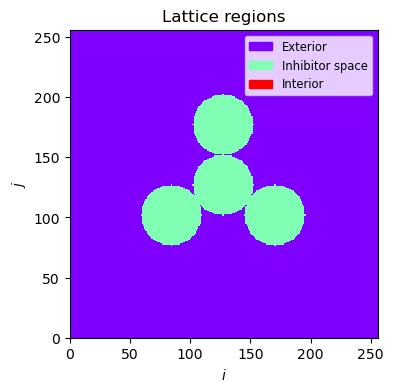

In [17]:
plot_lattice_regions(region_ids_all[6], zoom=1.0)

In [9]:
# Save results to files
path = @__DIR__

# Create experiment directory if it doesn't exist
if !isdir("$(path)/Data/280430_cluster_studies_100nm")
    mkdir("$(path)/Data/280430_cluster_studies_100nm")
end

jldopen(joinpath(path, "Data", "280430_cluster_studies_100nm", "280425_cluster_studies_100nm_sims.jld2"), "w") do file
    file["c_finals"] = c_finals
    file["nbr_nums"] = nbr_nums
    file["exponents"] = exponents
    file["param_set"] = param_set
end

12-element Vector{Tuple{Int64, Bool}}:
 (2, 1)
 (3, 1)
 (4, 1)
 (2, 0)
 (3, 0)
 (8, 1)
 (4, 0)
 (6, 1)
 (6, 0)
 (12, 1)
 (8, 0)
 (12, 0)

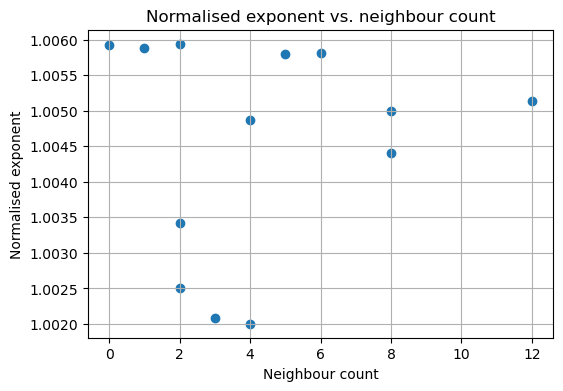

In [10]:
# Normalise exponents with tau
A_spore, V_spore = compute_spore_area_and_volume_from_dia(5.0)
tau = V_spore / (Ps_fit * A_spore)
exp_norm = -exponents .* tau

symmetric_mask = vcat([true], [ps[2] for ps in param_set])

# plot_functional_relationship(nbr_nums[symmetric_mask], exp_norm[symmetric_mask], ["Neighbour count", "Normalised exponent"], "Normalised exponent vs. neighbour count", fit=nothing, scatter=true)
plot_functional_relationship(nbr_nums, exp_norm, ["Neighbour count", "Normalised exponent"], "Normalised exponent vs. neighbour count", fit=nothing, scatter=true)
# plot_functional_relationship(nbr_nums, c_finals, ["Neighbour count", "c(1 h)"], "Final concentration vs. neighbour count", fit=nothing, scatter=true)

Once again, the results are noisy and vary only within a small range, possibly biased by discretisation through the number of contact sites.